# Statistical Analysis <a id='stats'></a>

1. Age group differences <br>
    1. [Memory task performance](#memory-performance) <br>
    2. [Network measures](#network-measures) <br>
    3. [Rest-activity measures](#rest-activity-measures) <br>
2. [NBS analysis](#nbs-analysis) <br>
3. Regression analyses <br>
    1. [Rest-activity measures and memory performance](#rar-memory) <br>
    2. [Functional connectivity and memory performance](#fc-memory) <br>
    3. [Rest-activity measures and functional connectivity](#rar-fc) <br>

In [96]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib  # load the beta maps in python
from nilearn import plotting  # plot nifti images
from bct import nbs
from scipy.io import savemat
from mne.viz import plot_connectivity_circle

In [97]:
data_dir = '/Volumes/psybrain/ADM/derivatives'
results_dir = '/Volumes/schnyer/Megan/adm_mem-fc/analysis/stats/'
nibs_dir='/Volumes/psybrain/ADM/derivatives/nibs/nibetaseries'

tasks = ['MemMatch1', 'MemMatch2', 'MemMatch3']
trial_types = ['cue', 'match', 'mismatch']

atlas_file='/Volumes/psybrain/ADM/derivatives/nibs/power264-master/power264MNI.nii.gz'
atlas_lut='/Volumes/psybrain/ADM/derivatives/nibs/power264_labels.tsv'

In [98]:
import re

hc = pd.read_csv('/Volumes/schnyer/Megan/adm_mem-fc/hc_dmn_fpn.csv')
hc['subject'] = hc['subject'].astype(str)

df0 = pd.read_csv('/Volumes/schnyer/Megan/adm_mem-fc/data/dataset_2021-11-10.csv')
df0['subject'] = df0['subject'].astype(str)

df = pd.merge(hc, df0, on='subject')

df = df.dropna(subset=['hc_dmn_fc'])
df['Group'] = np.where(df['subject'].astype(int) > 40000, "Older Adults", "Young Adults")
df = df.set_index('subject')
df

,hc_dmn_fc,hc_fpn_fc,dmn_fpn_fc,dmn_fc,fpn_fc,IS,IV,RA,L5,L5_starttime,...,pc_dmn_fpn_18,pc_dmn_fpn_20,pc_dmn_fpn_mean,pc_dmn_mean,pc_fpn_mean,edge_0,edge_1,edge_2,edge_3,acc_mean_test_log
subject,,,,,,,,,,,,,,,,,,,,,
30004,0.246789,0.065381,0.172766,0.329363,0.480001,0.43,0.57,0.85,12.61,19:54:30,...,0.205587,0.218853,0.178769,0.585333,0.755358,0.451471,0.509899,0.257227,0.688757,-0.028171
30008,0.460457,0.254719,0.275094,0.418964,0.495840,0.48,0.68,0.90,7.56,20:26:30,...,0.206955,0.218107,0.194311,0.586016,0.720762,0.425655,0.824386,1.032888,0.311497,-0.057158
30009,0.130394,0.029481,0.099538,0.228084,0.435712,0.42,1.31,0.92,11.58,19:34:30,...,0.211377,0.222053,0.192073,0.482981,0.814453,0.508419,0.634550,0.578941,0.278736,-0.028171
30015,-0.016112,-0.156934,0.079484,0.230274,0.300856,NaN,NaN,NaN,NaN,NaN,...,0.261610,0.277564,0.237269,0.651844,0.738657,0.264530,0.418911,0.402329,0.096133,-0.117783
30019,0.048041,-0.003531,0.186824,0.230634,0.389143,0.45,0.71,0.94,4.67,20:08:30,...,0.318376,0.331827,0.302502,0.715599,0.830522,0.365178,0.379545,0.701750,0.334316,-0.057158
30020,-0.032265,-0.052022,0.413680,0.499089,0.546660,0.63,0.72,0.94,6.32,19:27:30,...,0.234516,0.238569,0.214476,0.690589,0.742340,1.129555,0.482186,0.290999,1.015736,-0.251314
30023,0.261657,0.197951,0.290672,0.364596,0.435711,0.45,1.01,0.86,8.35,19:52:30,...,0.259999,0.278324,0.243712,0.608987,0.779721,0.193597,0.437271,0.817750,0.375620,-0.057158
30040,0.242890,0.299594,0.197774,0.216430,0.387534,0.43,1.12,0.90,8.51,22:16:30,...,0.324340,0.327024,0.299483,0.685136,0.810084,0.670385,0.435313,0.287747,0.322722,-0.028171
30057,0.285181,-0.029561,0.213210,0.326095,0.381124,0.60,0.68,0.96,4.19,19:13:30,...,0.287274,0.293760,0.264605,0.610554,0.768614,0.072768,0.378579,0.562540,0.173406,0.000000


In [99]:
df.groupby(['Group', 'sex'])['age', 'hc_dmn_fc', 'hc_fpn_fc'].describe()

age                                                 \
                    count       mean       std   min    25%   50%    75%   
Group        sex                                                           
Older Adults Female  31.0  67.000000  5.059644  60.0  63.00  66.0  71.00   
             Male     4.0  64.750000  3.774917  60.0  63.00  65.0  66.75   
Young Adults Female  28.0  21.535714  3.815001  18.0  18.75  20.0  23.25   
             Male    17.0  20.647059  3.219883  18.0  19.00  19.0  21.00   

                          hc_dmn_fc            ...                      \
                      max     count      mean  ...       75%       max   
Group        sex                               ...                       
Older Adults Female  79.0      31.0  0.232483  ...  0.319069  0.599973   
             Male    69.0       4.0  0.225944  ...  0.292492  0.350450   
Young Adults Female  30.0      28.0  0.218186  ...  0.268803  0.533801   
             Male    29.0      17.0  0.179491  ...  0.265432  0.487479   

                    hc_fpn_fc                                          \
                        count      mean       std       min       25%   
Group        sex                                                        
Older Adults Female      31.0  0.176852  0.167959 -0.146677  0.067779   
             Male         4.0  0.162122  0.094971  0.042649  0.107804   
Young Adults Female      28.0  0.083602  0.172002 -0.231529 -0.016162   
             Male        17.0  0.098895  0.131261 -0.156934 -0.009621   

                                                   
                          50%       75%       max  
Group        sex                                   
Older Adults Female  0.164571  0.263112  0.563185  
             Male    0.179382  0.233700  0.247073  
Young Adults Female  0.049945  0.161626  0.470777  
             Male    0.125489  0.166293  0.364140  

[4 rows x 24 columns]

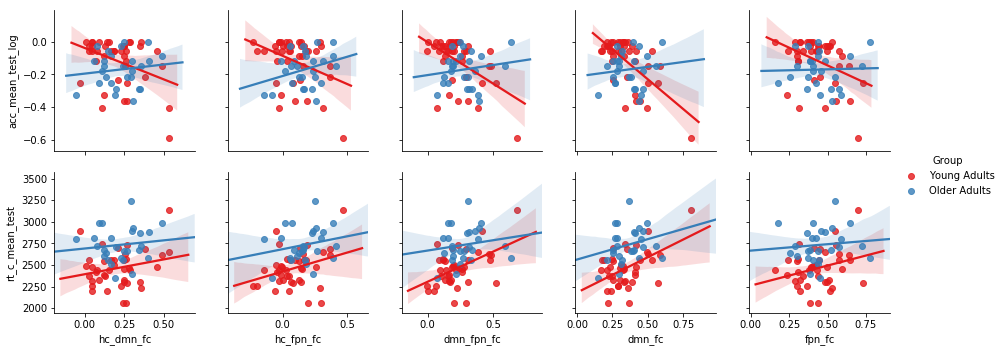

In [104]:
sns.pairplot(df[['hc_dmn_fc', 'hc_fpn_fc', 'dmn_fpn_fc', 'dmn_fc', 'fpn_fc', 'acc_mean_test_log', 'rt_c_mean_test', 'Group']][df['actamp'] < 3].dropna(), 
             hue='Group', x_vars=['hc_dmn_fc', 'hc_fpn_fc', 'dmn_fpn_fc', 'dmn_fc', 'fpn_fc'], y_vars=['acc_mean_test_log', 'rt_c_mean_test'],
             palette = 'Set1', kind='reg')

β = 0.23, t = 2.34, p = 0.022


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.5984,0.158,3.777,0.000,0.283,0.914
Group[T.Young Adults],-0.9677,0.203,-4.761,0.000,-1.373,-0.563
hc_fpn_fc,0.2313,0.099,2.343,0.022,0.035,0.428


<Figure size 2400x1800 with 0 Axes>

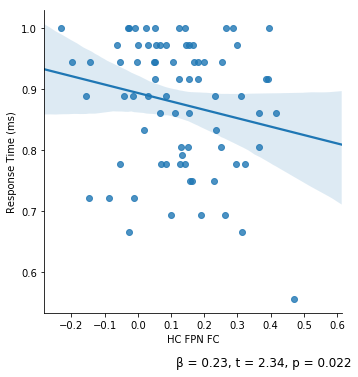

In [95]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

testvar = 'hc_fpn_fc'
plot_title = 'HC FPN FC'
x_pos = .5
y_pos = -0.03

regdf = df[['Group', 'hc_fpn_fc', 'rt_c_mean_test']].dropna()
regdf[['hc_fpn_fc', 'rt_c_mean_test']] = regdf[['hc_fpn_fc', 'rt_c_mean_test']].apply(zscore)
regdf = regdf[abs(regdf['hc_fpn_fc']) < 3]
# regdf = regdf[regdf['Group'] == "Older Adults"]

model = smf.ols(formula='rt_c_mean_test ~ hc_fpn_fc + Group', data=regdf).fit()
summary = model.summary()

#df = df.drop('40750')
plt.figure(figsize=(8, 6), dpi=300)
sns.lmplot(data=df, x='hc_fpn_fc', y="acc_mean_test", palette = 'Set1', legend_out=False)
plt.ylabel('Response Time (ms)'); plt.xlabel('HC FPN FC')

if model.pvalues[testvar] < 0.001:
    plt.text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), ha='center')
    print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
else:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

# plt.title('Paracingulate Gyrus - Frontal Orbital Cortex')
# plt.savefig(results_dir + 'scatter-%s.png' % plot_title, dpi=300, bbox_inches="tight")

summary.tables[1]

β = 0.22, t = 2.25, p = 0.027


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.6184,0.147,4.212,0.000,0.326,0.911
Group[T.Young Adults],-1.0458,0.190,-5.515,0.000,-1.424,-0.668
dmn_fpn_fc,0.2212,0.098,2.252,0.027,0.025,0.417


<Figure size 2400x1800 with 0 Axes>

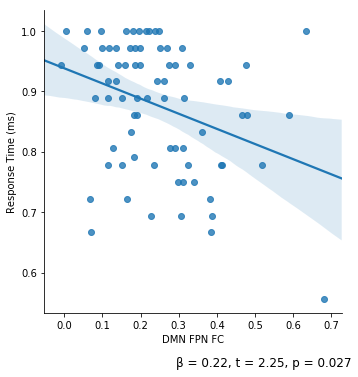

In [105]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

testvar = 'dmn_fpn_fc'
plot_title = 'DMN FPN FC'
x_pos = .5
y_pos = -0.03

regdf = df[['Group', 'dmn_fpn_fc', 'rt_c_mean_test']].dropna()
regdf[['dmn_fpn_fc', 'rt_c_mean_test']] = regdf[['dmn_fpn_fc', 'rt_c_mean_test']].apply(zscore)
regdf = regdf[abs(regdf['dmn_fpn_fc']) < 3]
# regdf = regdf[regdf['Group'] == "Older Adults"]

model = smf.ols(formula='rt_c_mean_test ~ dmn_fpn_fc + Group', data=regdf).fit()
summary = model.summary()

#df = df.drop('40750')
plt.figure(figsize=(8, 6), dpi=300)
sns.lmplot(data=df, x='dmn_fpn_fc', y="acc_mean_test", palette = 'Set1', legend_out=False)
plt.ylabel('Response Time (ms)'); plt.xlabel('DMN FPN FC')

if model.pvalues[testvar] < 0.001:
    plt.text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), ha='center')
    print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
else:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

# plt.title('Paracingulate Gyrus - Frontal Orbital Cortex')
# plt.savefig(results_dir + 'scatter-%s.png' % plot_title, dpi=300, bbox_inches="tight")

summary.tables[1]

β = 0.25, t = 2.48, p = 0.015


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.6468,0.145,4.472,0.000,0.358,0.935
Group[T.Young Adults],-1.0868,0.185,-5.862,0.000,-1.456,-0.717
dmn_fc,0.2475,0.100,2.482,0.015,0.049,0.446


<Figure size 2400x1800 with 0 Axes>

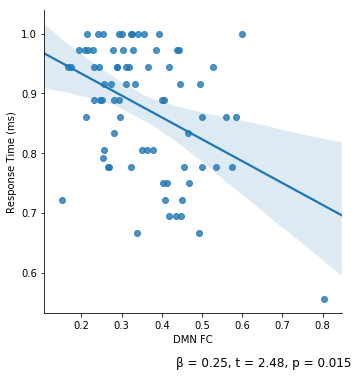

In [106]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore

testvar = 'dmn_fc'
plot_title = 'DMN FC'
x_pos = .5
y_pos = -0.03

regdf = df[['Group', 'dmn_fc', 'rt_c_mean_test']].dropna()
regdf[['dmn_fc', 'rt_c_mean_test']] = regdf[['dmn_fc', 'rt_c_mean_test']].apply(zscore)
regdf = regdf[abs(regdf['dmn_fc']) < 3]
# regdf = regdf[regdf['Group'] == "Older Adults"]

model = smf.ols(formula='rt_c_mean_test ~ dmn_fc + Group', data=regdf).fit()
summary = model.summary()

#df = df.drop('40750')
plt.figure(figsize=(8, 6), dpi=300)
sns.lmplot(data=df, x='dmn_fc', y="acc_mean_test", palette = 'Set1', legend_out=False)
plt.ylabel('Response Time (ms)'); plt.xlabel('DMN FC')

if model.pvalues[testvar] < 0.001:
    plt.text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]), ha='center')
    print('\u03B2 = %.2f, t = %.2f, p < 0.001' % (model.params[testvar], model.tvalues[testvar]))
else:
    plt.gcf().text(x_pos, y_pos, '\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]), fontsize=12)
    print('\u03B2 = %.2f, t = %.2f, p = %.3f' % (model.params[testvar], model.tvalues[testvar], model.pvalues[testvar]))

# plt.title('Paracingulate Gyrus - Frontal Orbital Cortex')
# plt.savefig(results_dir + 'scatter-%s.png' % plot_title, dpi=300, bbox_inches="tight")

summary.tables[1]

In [110]:
regdf = df[['Group', 'dmn_fpn_fc', 'dmn_fc', 'fpn_fc', 'rt_c_mean_test']].dropna()
regdf[['dmn_fpn_fc', 'dmn_fc', 'fpn_fc', 'rt_c_mean_test']] = regdf[['dmn_fpn_fc', 'dmn_fc', 'fpn_fc', 'rt_c_mean_test']].apply(zscore)
regdf = regdf[abs(regdf['dmn_fpn_fc']) < 3]
regdf = regdf[abs(regdf['dmn_fc']) < 3]
regdf = regdf[abs(regdf['fpn_fc']) < 3]
# regdf = regdf[regdf['Group'] == "Older Adults"]

model = smf.ols(formula='rt_c_mean_test ~ dmn_fpn_fc + fpn_fc + Group', data=regdf).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rt_c_mean_test   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     14.38
Date:                Fri, 18 Feb 2022   Prob (F-statistic):           2.05e-07
Time:                        12:57:01   Log-Likelihood:                -86.082
No. Observations:                  75   AIC:                             180.2
Df Residuals:                      71   BIC:                             189.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.6063      0.147      4.118      0.000       0.313       0.900
Group[T.Young Adults]    -1.0245      0.191     -5.370      0.000      -1.405      -0.644
dmn_fpn_fc                0.3422      0.154      2.216      0.030       0.034       0.650
fpn_fc                   -0.1481      0.146     -1.015      0.313      -0.439       0.143
==============================================================================
Omnibus:                        1.139   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.566   Jarque-Bera (JB):                0.676
Skew:                           0.214   Prob(JB):                        0.713
Kurtosis:                       3.183   Cond. No.                         3.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

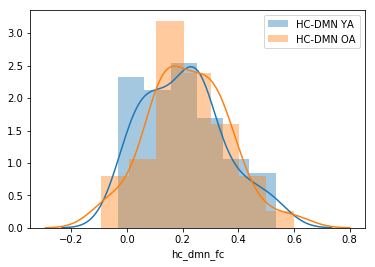

In [114]:
sns.distplot(df[df['Group'] == "Young Adults"]['hc_dmn_fc'], label = 'HC-DMN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['hc_dmn_fc'], label = 'HC-DMN OA')
plt.legend()

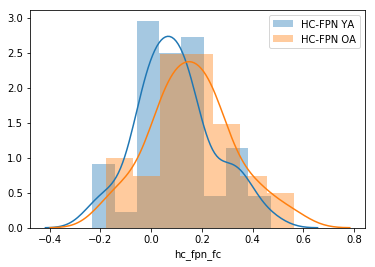

In [115]:
sns.distplot(df[df['Group'] == "Young Adults"]['hc_fpn_fc'], label = 'HC-FPN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['hc_fpn_fc'], label = 'HC-FPN OA')
plt.legend()

In [120]:
from scipy import stats
stats.ttest_ind(df[df['Group'] == "Young Adults"]['hc_fpn_fc'], df[df['Group'] == "Older Adults"]['hc_fpn_fc'], equal_var=True)

Ttest_indResult(statistic=-1.9160378542651693, pvalue=0.0586824390788433)

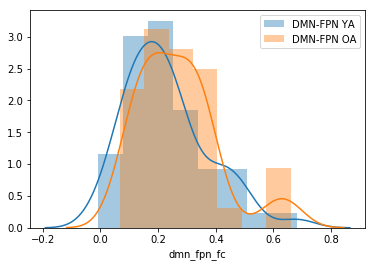

In [116]:
sns.distplot(df[df['Group'] == "Young Adults"]['dmn_fpn_fc'], label = 'DMN-FPN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['dmn_fpn_fc'], label = 'DMN-FPN OA')
plt.legend()

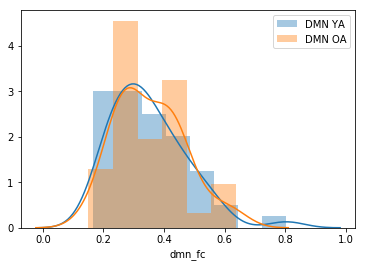

In [117]:
sns.distplot(df[df['Group'] == "Young Adults"]['dmn_fc'], label = 'DMN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['dmn_fc'], label = 'DMN OA')
plt.legend()

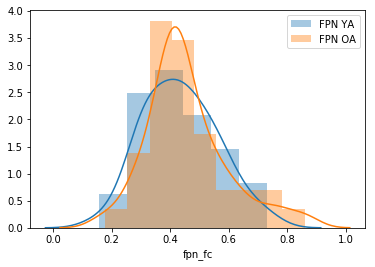

In [118]:
sns.distplot(df[df['Group'] == "Young Adults"]['fpn_fc'], label = 'FPN YA')
sns.distplot(df[df['Group'] == "Older Adults"]['fpn_fc'], label = 'FPN OA')
plt.legend()